# Deep Convolutional Generative Adversarial Network (DCGAN) Tutorial

This tutorials walks through an implementation of DCGAN as described in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

To learn more about generative adversarial networks, see my [Medium post](https://medium.com/p/54deab2fce39) on them.

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

In [28]:
%matplotlib inline

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper Functions

In [3]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided  transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [4]:
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network
The discriminator network takes as input a 32x32 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [5]:
def discriminator(bottom, reuse=False):
    
    dis1 = slim.convolution2d(bottom,16,[4,4],stride=[2,2],padding="SAME",\
        biases_initializer=None,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv1',weights_initializer=initializer)
    
    dis2 = slim.convolution2d(dis1,32,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    
    dis3 = slim.convolution2d(dis2,64,[4,4],stride=[2,2],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    
    d_out = slim.fully_connected(slim.flatten(dis3),1,activation_fn=tf.nn.sigmoid,\
        reuse=reuse,scope='d_out', weights_initializer=initializer)
    
    return d_out

### Connecting them together

In [6]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
Now that we have fully defined our network, it is time to train it!

In [14]:
batch_size = 16 #Size of image batch to apply at each iteration.
iterations = 10000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print ("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            #save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print ("Saved Model")

Gen Loss: 0.289768 Disc Loss: 1.55307
Gen Loss: 0.21409 Disc Loss: 2.01614
Gen Loss: 0.340757 Disc Loss: 1.95377
Gen Loss: 0.535975 Disc Loss: 1.75118
Gen Loss: 0.715503 Disc Loss: 1.52133
Gen Loss: 0.588635 Disc Loss: 1.75493
Gen Loss: 0.691759 Disc Loss: 1.49491
Gen Loss: 0.826789 Disc Loss: 1.52939
Gen Loss: 0.764096 Disc Loss: 1.49746
Gen Loss: 0.854176 Disc Loss: 1.36628
Gen Loss: 0.860045 Disc Loss: 1.33524
Gen Loss: 0.74409 Disc Loss: 1.43806
Gen Loss: 0.792733 Disc Loss: 1.399
Gen Loss: 0.853702 Disc Loss: 1.51812
Gen Loss: 0.855788 Disc Loss: 1.39641
Gen Loss: 1.19717 Disc Loss: 1.06158
Gen Loss: 0.5876 Disc Loss: 1.63713
Gen Loss: 0.661258 Disc Loss: 1.4365
Gen Loss: 1.20765 Disc Loss: 0.87197
Gen Loss: 1.11869 Disc Loss: 1.02742
Gen Loss: 0.434067 Disc Loss: 1.77069
Gen Loss: 0.902206 Disc Loss: 1.2196
Gen Loss: 0.979022 Disc Loss: 1.19168
Gen Loss: 2.17373 Disc Loss: 0.337141
Gen Loss: 2.56994 Disc Loss: 0.221819
Gen Loss: 0.514688 Disc Loss: 2.36981
Gen Loss: 1.06086 Disc 

Gen Loss: 1.10375 Disc Loss: 0.975712
Gen Loss: 1.27683 Disc Loss: 0.881377
Gen Loss: 1.19909 Disc Loss: 1.00015
Gen Loss: 1.61747 Disc Loss: 0.657199
Gen Loss: 1.38317 Disc Loss: 0.986403
Gen Loss: 0.94899 Disc Loss: 1.27113
Gen Loss: 2.1342 Disc Loss: 0.340827
Gen Loss: 1.93802 Disc Loss: 0.630129
Gen Loss: 1.62913 Disc Loss: 0.656727
Gen Loss: 1.45516 Disc Loss: 0.718656
Gen Loss: 1.74658 Disc Loss: 0.843336
Gen Loss: 1.25731 Disc Loss: 0.772681
Gen Loss: 1.06081 Disc Loss: 1.49185
Gen Loss: 1.20097 Disc Loss: 0.901113
Gen Loss: 1.13506 Disc Loss: 1.12579
Gen Loss: 1.05336 Disc Loss: 1.08942
Gen Loss: 0.887609 Disc Loss: 1.16804
Gen Loss: 1.7222 Disc Loss: 0.799442
Gen Loss: 1.13345 Disc Loss: 1.10965
Gen Loss: 1.48108 Disc Loss: 0.78666
Gen Loss: 1.66678 Disc Loss: 0.594802
Gen Loss: 1.73011 Disc Loss: 0.815831
Gen Loss: 1.23964 Disc Loss: 0.829121
Gen Loss: 1.07707 Disc Loss: 0.753547
Gen Loss: 1.38097 Disc Loss: 1.4034
Gen Loss: 1.49178 Disc Loss: 0.860231
Gen Loss: 1.42902 Disc 

Gen Loss: 1.05857 Disc Loss: 0.748657
Gen Loss: 1.42935 Disc Loss: 0.918655
Gen Loss: 1.81839 Disc Loss: 0.540166
Gen Loss: 2.00082 Disc Loss: 0.724719
Gen Loss: 2.17855 Disc Loss: 0.220988
Gen Loss: 2.31912 Disc Loss: 0.35049
Gen Loss: 2.61572 Disc Loss: 0.444468
Gen Loss: 1.75806 Disc Loss: 0.316903
Gen Loss: 2.26837 Disc Loss: 0.383952
Gen Loss: 2.11982 Disc Loss: 0.379381
Gen Loss: 2.06506 Disc Loss: 0.325948
Gen Loss: 2.34672 Disc Loss: 0.316264
Gen Loss: 2.14885 Disc Loss: 0.558686
Gen Loss: 2.11235 Disc Loss: 0.425544
Gen Loss: 1.81234 Disc Loss: 0.437848
Gen Loss: 1.48597 Disc Loss: 0.698689
Gen Loss: 1.98935 Disc Loss: 0.601121
Gen Loss: 1.11875 Disc Loss: 0.895433
Gen Loss: 2.00174 Disc Loss: 0.581985
Gen Loss: 1.8195 Disc Loss: 0.475083
Gen Loss: 1.22013 Disc Loss: 0.808609
Gen Loss: 1.77555 Disc Loss: 0.500855
Gen Loss: 1.59589 Disc Loss: 0.461303
Gen Loss: 2.04781 Disc Loss: 0.519144
Gen Loss: 2.14639 Disc Loss: 0.416748
Gen Loss: 3.22642 Disc Loss: 0.271229
Gen Loss: 1.40

Gen Loss: 1.63518 Disc Loss: 0.512847
Gen Loss: 1.64857 Disc Loss: 0.876531
Gen Loss: 2.06255 Disc Loss: 0.263691
Gen Loss: 1.94766 Disc Loss: 0.212303
Gen Loss: 2.76047 Disc Loss: 0.277289
Gen Loss: 2.58456 Disc Loss: 0.290984
Gen Loss: 2.42071 Disc Loss: 0.313112
Gen Loss: 2.50669 Disc Loss: 0.252246
Gen Loss: 1.76738 Disc Loss: 0.448206
Gen Loss: 2.05309 Disc Loss: 0.353318
Gen Loss: 1.19555 Disc Loss: 0.68567
Gen Loss: 1.73197 Disc Loss: 0.515851
Gen Loss: 1.39174 Disc Loss: 0.634054
Gen Loss: 2.04131 Disc Loss: 0.171079
Gen Loss: 2.5725 Disc Loss: 0.329131
Gen Loss: 1.62914 Disc Loss: 0.501752
Gen Loss: 2.42886 Disc Loss: 0.270976
Gen Loss: 1.51815 Disc Loss: 0.432627
Gen Loss: 2.33541 Disc Loss: 0.437812
Gen Loss: 1.32107 Disc Loss: 0.688165
Gen Loss: 2.35359 Disc Loss: 1.15119
Gen Loss: 1.86592 Disc Loss: 0.751316
Gen Loss: 2.06555 Disc Loss: 0.435469
Gen Loss: 2.237 Disc Loss: 0.299729
Gen Loss: 2.10628 Disc Loss: 0.361113
Gen Loss: 2.11231 Disc Loss: 0.161764
Gen Loss: 1.99017

Gen Loss: 1.50505 Disc Loss: 0.233162
Gen Loss: 2.41518 Disc Loss: 0.457365
Gen Loss: 2.70105 Disc Loss: 0.821257
Gen Loss: 2.20656 Disc Loss: 0.271459
Gen Loss: 1.84468 Disc Loss: 1.09376
Gen Loss: 1.09808 Disc Loss: 0.278311
Gen Loss: 2.48201 Disc Loss: 0.0607496
Gen Loss: 2.46173 Disc Loss: 0.504972
Gen Loss: 2.38348 Disc Loss: 0.323011
Gen Loss: 1.83819 Disc Loss: 0.55583
Gen Loss: 1.49881 Disc Loss: 0.496647
Gen Loss: 2.85894 Disc Loss: 0.251162
Gen Loss: 2.1955 Disc Loss: 0.541567
Gen Loss: 0.958698 Disc Loss: 0.933514
Gen Loss: 2.67118 Disc Loss: 0.203243
Gen Loss: 2.62586 Disc Loss: 0.245414
Gen Loss: 1.82761 Disc Loss: 0.592739
Gen Loss: 2.43876 Disc Loss: 0.317017
Gen Loss: 2.35558 Disc Loss: 0.23567
Gen Loss: 1.84949 Disc Loss: 0.477985
Gen Loss: 1.3358 Disc Loss: 0.40874
Gen Loss: 1.77781 Disc Loss: 0.455463
Gen Loss: 1.97431 Disc Loss: 0.382409
Gen Loss: 2.33616 Disc Loss: 0.301752
Gen Loss: 1.82586 Disc Loss: 0.586694
Gen Loss: 2.4172 Disc Loss: 0.273042
Gen Loss: 2.53952

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [24]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 1

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print ('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    zs = np.random.uniform(-1.0,1.0,size=[1,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    ## save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
    
    my_i = newZ.squeeze()
    plt.imshow(my_i[1,:,:], cmap='gray_r')

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-9000.cptk


TypeError: Invalid dimensions for image data

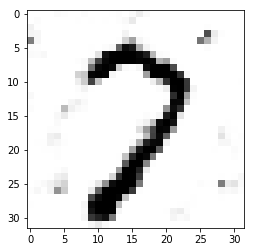

In [32]:
plt.imshow(my_i[8,:,:], cmap='gray_r')